In [1]:
import torch
import numpy as np
from nilearn import plotting
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import RobustScaler
from brainscore.get_brain_score_speech import get_mean_bold
from brainscore import paths as PATHS
from nibabel.freesurfer.io import read_geometry, read_morph_data
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_brain(hemi='lh', PATHS=PATHS):
    """for advanced plotting"""
    out = dict()
    out['hemi'] = 'left' if hemi == 'lh' else 'right'
    
    # surface
    pial, faces = read_geometry(str(PATHS.surf_dir / f"{hemi}.pial"))
    infl, faces = read_geometry(str(PATHS.surf_dir / f"{hemi}.inflated"))
    a = .5
    
    out['surf_mesh'] = (pial*a + infl*(1-a)), faces
    
    # background
    bkg = read_morph_data(PATHS.surf_dir/'lh.avg_curv')
    out['bg_map'] = ((bkg>np.percentile(bkg, 50))-.5)*bkg.ptp()
    out['bg_map'][0] = -1.
    out['bg_map'][1] = 1.
    out['darkness'] = .6
    
    return out

In [3]:
def correlate(X, Y):
    """n-way pearson correlation"""
    if X.ndim == 1:
        X = X[:, None]
    if Y.ndim == 1:
        Y = Y[:, None]
    out = np.zeros(max([Y.shape[1], X.shape[1]]))
    X = X - X.mean(0)
    Y = Y - Y.mean(0)

    SX2 = (X ** 2).sum(0) ** 0.5
    SY2 = (Y ** 2).sum(0) ** 0.5
    SXY = (X * Y).sum(0)
    valid = (SX2 != 0) & (SY2 != 0)
    out[valid] = SXY[valid] / (SX2[valid] * SY2[valid])
    return out


def pad(feats, len_bold):
    missing = len_bold - len(feats)
    if missing>0:
        print('padding...')
        pads = np.zeros((missing, len(feats.T)))
        feats = np.vstack([feats, pads])
    elif missing < 0:
        print(f'missing {-missing} TR...')
        feats = feats[:missing]
    return feats


class Scaler(RobustScaler):
    def transform(self, X, y=None):
        X = super(Scaler, self).transform(X)
        return np.clip(np.nan_to_num(X), -5, 5)
    

class Mapper():
    def __init__(self, ):
        self.model = RidgeCV(np.logspace(-1, 8, 10), fit_intercept=True, alpha_per_target=True)
        self.x_preproc = Scaler(quantile_range=(0.1, 99.9))
        self.y_preproc = Scaler(quantile_range=(0.1, 99.9))
            
    def fit(self, X, Y):
        # x
        X = self.x_preproc.fit_transform(X)
        
        # y
        self._y_valid = Y.std(0)>0
        Y = Y[:, self._y_valid]
        Y = self.y_preproc.fit_transform(Y)
        
        # model
        self.model.fit(X, Y)

    def predict(self, X):
        # preproc
        X = self.x_preproc.transform(X)
        
        # predict
        Y_hat_ = self.model.predict(X)
        
        # inverse Y
        Y_hat = np.zeros((len(X), len(self._y_valid)))
        Y_hat[:, self._y_valid] = self.y_preproc.inverse_transform(Y_hat_)
        return Y_hat

    def score(self, X, Y):
        Y_true = np.zeros_like(Y)
        Y_true[:, self._y_valid] = self.y_preproc.transform(Y[:, self._y_valid])
        Y_hat = self.predict(X)
        r = correlate(Y_true, Y_hat)
        r[~self._y_valid] = 0
        return r

In [4]:
bolds = get_mean_bold(hemi='L')

In [5]:
task = 'pieman'
Y = bolds[task]

X = list()
for layer in ('conv', 'tr'):
    x = torch.load(PATHS.speech_embeddings / "minimal" / f"{task}_{layer}.pth")
    X.append(np.hstack(x))
X = pad(np.hstack(X), len(Y))

missing 10 TR...


In [6]:
# Fit
mapper = Mapper()
train = np.arange(len(Y)) > (len(Y)//2)
test = ~train

mapper.fit(X[train], Y[train])
Y_pred = mapper.predict(X[test])
r = correlate(Y_pred, Y[test])
print(r.max())

0.7884889418320093


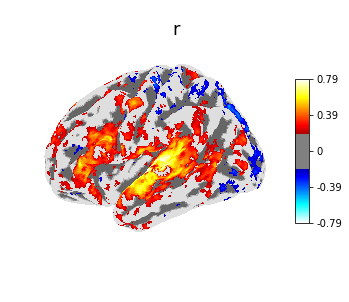

In [7]:
# Plot
im = plotting.plot_surf_stat_map(
    **get_brain(),
    stat_map=r,
    view='lateral',
    cmap='cold_hot',
    symmetric_cbar=True,
    threshold=.2,
    colorbar=True,
    title='r',
)

In [8]:
wav, sr = librosa.load(PATHS.stimuli/f'{task}_audio.wav')
times = np.arange(len(wav))/sr

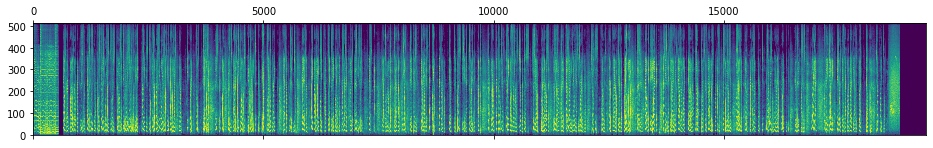

In [9]:
spec = librosa.feature.melspectrogram(y=wav,
                                      sr=sr,
                                      n_fft=2048*4, 
                                      hop_length=512,
                                      win_length=None,
                                      window='hann', 
                                      center=True, 
                                      pad_mode='reflect', 
                                      power=2.0,
                                      n_mels=512)
spec = np.log10(spec)
spec = np.clip((spec+4) / 7, 0, 1)
plt.matshow(spec, aspect='auto', origin='lower')

In [10]:
cherry_pick = r.argmax()


In [ ]:
%re

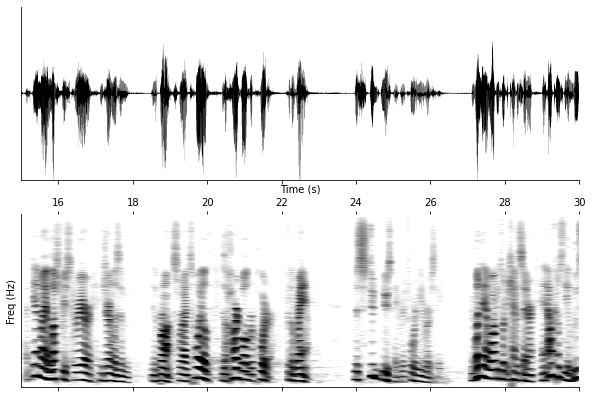

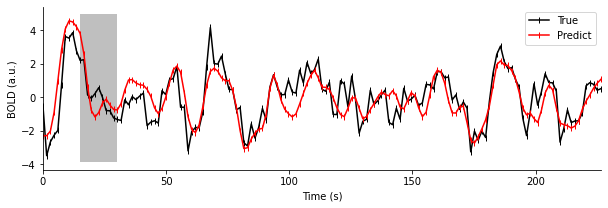

In [45]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=[10, 7], sharex=True)
decim = 10
ax0.plot(times[::decim], wav[::decim], lw=.1, color='k')
ax0.set_yticks([])
ax0.set_ylim(-.5, .5)
ax1.matshow(spec**2, aspect='auto', origin='lower', 
            extent=[times[0], times[-1], 0, 1], 
            cmap='gray_r', vmin=.1, vmax=.8)
xlim = (15, 30)
ax1.set_xlim(*xlim)
ax0.set_xlabel("Time (s)")
ax1.set_ylabel("Freq (Hz)")
ax1.set_yticks([])
sns.despine(fig)

times_bold = np.linspace(times[0], times[-1]*test.mean(), sum(test))
fig, ax = plt.subplots(1, figsize=[10, 3])
ax.plot(times_bold, Y[test, cherry_pick], color='k', marker='|', label='True')
ax.plot(times_bold, Y_pred[:, cherry_pick], color='r', marker='|', label='Predict')
ax.set_xlim(times_bold[0], times_bold[-1])
ylim = ax.get_ylim()
ax.fill_between([xlim[0], xlim[0], xlim[1], xlim[1], xlim[0]], 
                [ylim[0], ylim[1], ylim[1], ylim[0], ylim[0]], 
                color='k', alpha=.25, lw=0)
ax.set_xlabel("Time (s)")
ax.set_ylabel("BOLD (a.u.)")
plt.legend()
sns.despine(fig)